In [3]:
!pip install darts statsmodels prophet seaborn pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 424 kB 8.9 MB/s 
     |████████████████████████████████| 636 kB 42.5 MB/s 
     |████████████████████████████████| 44 kB 2.0 MB/s 
     |████████████████████████████████| 1.8 MB 44.5 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 11.2 MB 47.6 MB/s 
     |████████████████████████████████| 705 kB 59.2 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 9.8 MB 43.4 MB/s 
     |████████████████████████████████| 1.6 MB 56.6 MB/s 
     |████████████████████████████████| 950 kB 44.3 MB/s 
     |████████████████████████████████| 419 kB 57.2 MB/s 
     |████████████████████████████████| 5.9 MB 47.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninsta

In [1]:
import time
t_start1 = time.perf_counter()

%matplotlib inline

## Importing Libraries
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce

import pmdarima as pmd
import statsmodels.api as sm 
from scipy.stats import normaltest

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
)
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_pacf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox


from darts.datasets import AirPassengersDataset, AusBeerDataset, GasRateCO2Dataset 
from darts.datasets import HeartRateDataset, IceCreamHeaterDataset, MonthlyMilkDataset
from darts.datasets import SunspotsDataset


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [2]:
ts = MonthlyMilkDataset().load()

In [9]:
ts

<TimeSeries (DataArray) (Month: 168, component: 1, sample: 1)>
array([[[589.]],

       [[561.]],

       [[640.]],

       [[656.]],

       [[727.]],

       [[697.]],

       [[640.]],

       [[599.]],

       [[568.]],

       [[577.]],

...

       [[892.]],

       [[903.]],

       [[966.]],

       [[937.]],

       [[896.]],

       [[858.]],

       [[817.]],

       [[827.]],

       [[797.]],

       [[843.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1962-01-01 1962-02-01 ... 1975-12-01
  * component  (component) object 'Pounds per cow'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### Soal:

Bandingkan ketiga model ini:
1. Naive Seasonal
2. Naive Drift 
3. Exponential Smoothing (lakukan pemilihan juga, terkait additive/multiplicative trend and seasonality)

Mana model yang memberikan RMSE terbaik?

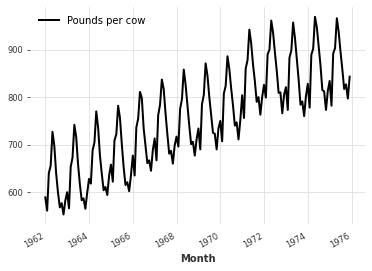

In [7]:
ts.plot()

### Jawaban

In [10]:
# Mengecek seasonality
check_seasonality(ts, m = 5, alpha = 0.05)

(False, 5)

In [12]:
# coba cek dari 2 sampai 25
for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(ts, m=m, alpha=0.05)
    if is_seasonal == True:
        print('Seasonality Detected! Seasonal period = ', m)
        break

Seasonality Detected! Seasonal period =  12


TS Test ada 35 satuan.


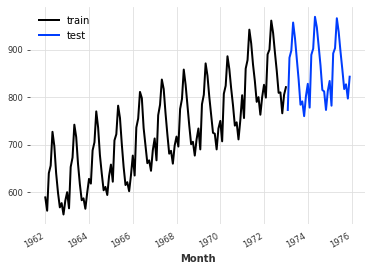

In [13]:
ts_train, ts_test = ts.split_before(0.8)
ts_train.plot(label = 'train')
ts_test.plot(label = 'test')
print('TS Test ada', len(ts_test), 'satuan.')

Naive Seasonal

Fitting the time series model takes 0.003415346145629883 seconds.


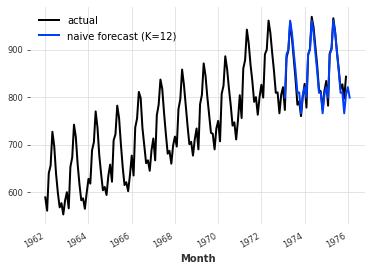

In [15]:
series = ts
seasonal_model = NaiveSeasonal(K=12)
start = time.time() #mulai
seasonal_model.fit(ts_train)
end = time.time() #selesai
seasonal_forecast = seasonal_model.predict(37)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

print('Fitting the time series model takes', end-start, 'seconds.')

In [16]:
def evaluate(actual_test, prediction):
    print(f'RMSE: {rmse(actual_test, prediction)}')
    print(f'R2: {r2_score(actual_test, prediction)}')
    print(f'MAPE: {mape(actual_test, prediction)}')

In [17]:
evaluate(ts_test, seasonal_forecast)

RMSE: 13.996938440755025
R2: 0.9467503266048011
MAPE: 1.2903614652869555


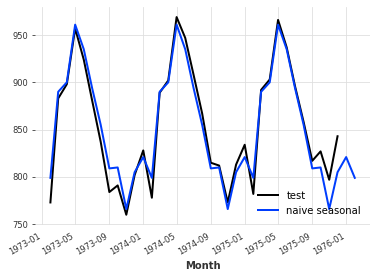

In [18]:
ts_test.plot(label = 'test')
seasonal_forecast.plot(label = 'naive seasonal')

Naive Drift

RMSE: 33.42992106176718
R2: 0.6962463218818822
MAPE: 3.644081166253636
Fitting the time series model takes 0.0003123283386230469 seconds.


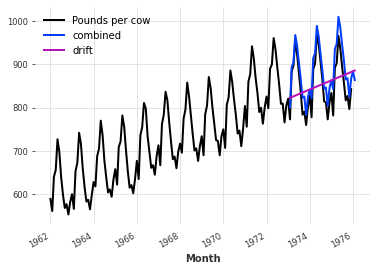

In [19]:
# Naive Drift memperbolehkan komponen trend dalam prediksi Naive Seasonal
drift_model = NaiveDrift()
start = time.time()
drift_model.fit(ts_train)
end = time.time()
drift_forecast = drift_model.predict(37)

combined_forecast = drift_forecast + seasonal_forecast - ts_train.last_value()
evaluate(ts_test, combined_forecast)

print('Fitting the time series model takes', end - start, 'seconds.')
series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

Model Naive drift pada prediksi ini ternyata tidak lebih baik dari Naive Seasonal karena seperti terlihat di atas nilai RMSE nya menjadi lebih besar dan nilai R2 nya juga lebih kecil yaitu 0.6 

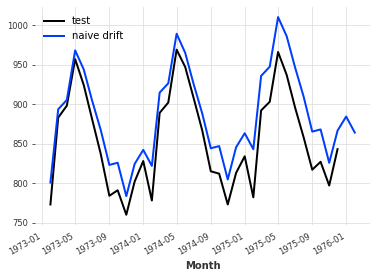

In [21]:
ts_test.plot(label = 'test')
combined_forecast.plot(label = 'naive drift')

Exponential Smoothing

RMSE: 69.80784360589841
R2: -0.3245223427880084
MAPE: 6.309354432206364
Fitting the time series model takes 0.03731131553649902 seconds.


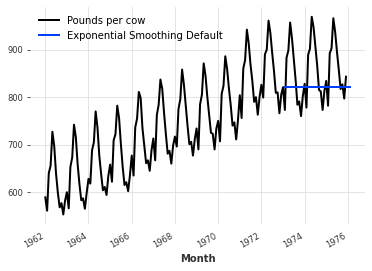

In [22]:
from darts.utils.utils import ModelMode, SeasonalityMode

expo_smooth = ExponentialSmoothing(trend = ModelMode.NONE, seasonal = SeasonalityMode.NONE)
start = time.time()
expo_smooth.fit(ts_train)
end = time.time()
expo_smooth_forecast = expo_smooth.predict(37)

series.plot()
expo_smooth_forecast.plot(label = 'Exponential Smoothing Default')

evaluate(ts_test, expo_smooth_forecast)
print('Fitting the time series model takes', end - start, 'seconds.')

Trial dengan beberapa kombinasi

*  Additive Trend, Additive Seasonality
*   Additive Trend, Multiplicative Seasonality
*   Multiplicative Trend, Additive Seasonality
*   Multiplicative Trend, Multiplicative Seasonality

In [23]:
from darts.utils.utils import ModelMode, SeasonalityMode

RMSE: 23.75979346681328
R2: 0.8465608564717477
MAPE: 2.404921765474775
Fitting the time series model takes 0.13174057006835938 seconds.


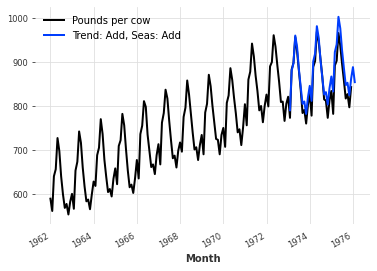

In [24]:
# Additive Trend, Additive Seasonality

expo_smooth = ExponentialSmoothing(trend = ModelMode('additive'), seasonal = SeasonalityMode('additive'))
start = time.time()
expo_smooth.fit(ts_train)
end = time.time()
expo_smooth_forecast = expo_smooth.predict(37)

series.plot()
expo_smooth_forecast.plot(label = 'Trend: Add, Seas: Add')

evaluate(ts_test, expo_smooth_forecast)

print('Fitting the time series model takes', end - start, 'seconds.')

RMSE: 29.68361259248679
R2: 0.7605116714039459
MAPE: 3.0777394125735444
Fitting the time series model takes 0.16221904754638672 seconds.


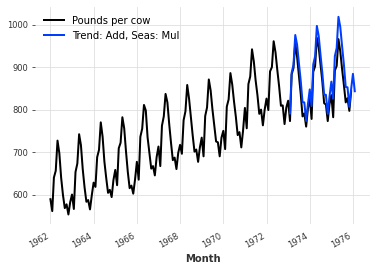

In [25]:
# Additive Trend, Multiplicative Seasonality
expo_smooth = ExponentialSmoothing(trend = ModelMode('additive'), seasonal = SeasonalityMode('multiplicative'))
start = time.time()
expo_smooth.fit(ts_train)
end = time.time()
expo_smooth_forecast = expo_smooth.predict(37)

series.plot()
expo_smooth_forecast.plot(label = 'Trend: Add, Seas: Mul')

evaluate(ts_test, expo_smooth_forecast)
print('Fitting the time series model takes', end - start, 'seconds.')

RMSE: 29.450916006726516
R2: 0.764251760891739
MAPE: 2.9925924583395784
Fitting the time series model takes 0.16121935844421387 seconds.


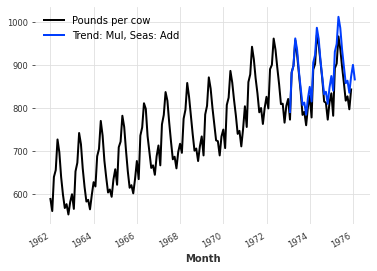

In [26]:
#Multiplicative Trend, Additive Seasonality

expo_smooth = ExponentialSmoothing(trend = ModelMode('multiplicative'), seasonal = SeasonalityMode('additive'))
start = time.time()
expo_smooth.fit(ts_train)
end = time.time()
expo_smooth_forecast = expo_smooth.predict(37)

series.plot()
expo_smooth_forecast.plot(label = 'Trend: Mul, Seas: Add')

evaluate(ts_test, expo_smooth_forecast)
print('Fitting the time series model takes', end - start, 'seconds.')

RMSE: 34.6411914909398
R2: 0.6738356536195996
MAPE: 3.625719890335884
Fitting the time series model takes 0.16348981857299805 seconds.


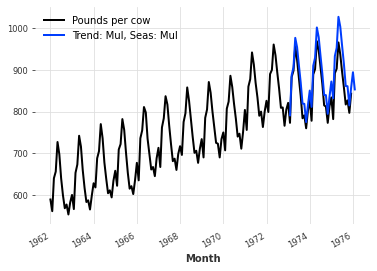

In [27]:
# Multiplicative Trend, multiplicative Seasonality
expo_smooth = ExponentialSmoothing(trend = ModelMode('multiplicative'), seasonal = SeasonalityMode('multiplicative'))
start = time.time()
expo_smooth.fit(ts_train)
end = time.time()
expo_smooth_forecast = expo_smooth.predict(37)

series.plot()
expo_smooth_forecast.plot(label = 'Trend: Mul, Seas: Mul')

evaluate(ts_test, expo_smooth_forecast)

print('Fitting the time series model takes', end - start, 'seconds.')

Dari ke empat trial model exp smoothing yang terbaik adalah model dengan 
** Trend Additive,  Seasonality Additive**

Namun jika dibandingkan dengan Naive Seasonal model Exp Smoothing tidak lebih baik karena angka RMSE nya masih lebih besar dan R2 nya juga lebih kecil. Sehingga untuk prediksi model yang digunakan adalah **Naive Seasonal**